# Fraud Detection with GAT

## Data Pre-processing

In [83]:
import torch
import torch_geometric
import torch_scatter
import torch_sparse
import pandas as pd

In [84]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [85]:
PATH='bitcoin_dataset'

In [86]:
!ls bitcoin_dataset

elliptic_txs_classes.csv
elliptic_txs_edgelist.csv
elliptic_txs_features.csv


In [87]:
classes_file = PATH + '/elliptic_txs_classes.csv'
edge_file    = PATH + '/elliptic_txs_edgelist.csv'
feature_file = PATH + '/elliptic_txs_features.csv'

In [88]:
data_classes=pd.read_csv(classes_file)
data_classes.head(5)

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown


In [89]:
data_classes['class'].unique()
# 1 - licit
# 2 - illicit

array(['unknown', '2', '1'], dtype=object)

In [90]:
# data_classes.head(5000)['class']

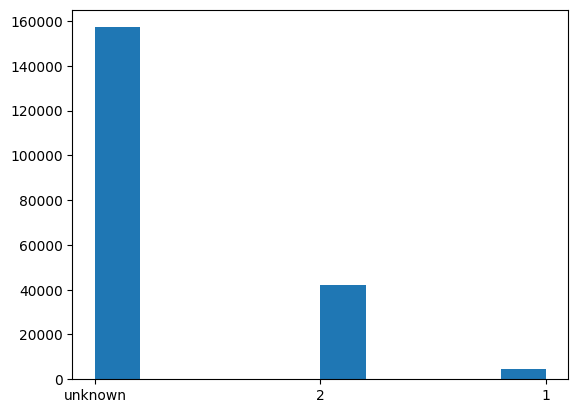

In [91]:
from matplotlib import pyplot as plt
plt.hist(data_classes['class'])
plt.show()

In [92]:
num_nodes=len(data_classes)
num_nodes

203769

In [93]:
data_classes['class']=data_classes['class'].map({'unknown':2,'1':1,'2':0})
data_classes.head(5)

,txId,class
0,230425980,2
1,5530458,2
2,232022460,2
3,232438397,0
4,230460314,2


In [94]:
data_edges=pd.read_csv(edge_file)
data_edges.head(5)
# edges between two nodes

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [95]:
data_features=pd.read_csv(feature_file,header=None)
data_features.head(5)
# 166-dim feature for each node

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [96]:
# merging class data and features data
data_classes_and_features=data_features.merge(data_classes,how='left',right_on="txId",left_on=0)
data_classes_and_features = data_classes_and_features.sort_values(0).reset_index(drop=True)
data_classes_and_features.head()

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,txId,class
0,1076,48,-0.168500,0.270909,-0.091383,-0.046932,-0.043875,-0.029140,-0.061584,-0.163591,...,1.461330,1.461369,0.018279,0.470019,1.216796,1.151607,1.519700,1.521399,1076,2
1,2534,6,-0.170834,-0.131425,1.018602,0.028105,0.055376,0.054722,-0.061584,-0.163572,...,0.955101,0.459257,-0.098889,-0.087490,-0.099080,-0.122137,-0.379970,-0.379288,2534,0
2,3181,34,1.305212,-0.210553,-1.756361,-0.121970,97.300650,-0.113002,-0.061584,1.348765,...,0.059948,0.113967,-0.098889,1.969527,0.037532,-0.131010,0.006994,0.017772,3181,0
3,3321,1,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,...,0.241128,0.241406,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,3321,2
4,3889,48,-0.086232,-0.101835,-0.646376,-0.121970,17.046997,-0.113002,-0.061584,-0.074885,...,0.082065,0.114773,-0.098889,8.948005,1.024948,-0.009570,-0.080708,-0.123601,3889,2


In [97]:
# The Node IDs or the transaction IDs are too large , so not feasible. We will map them to indices
# data_classes_and_features.head(200)

In [98]:
data_classes_and_features[0].values

array([     1076,      2534,      3181, ..., 403234715, 403235564,
       403244581], dtype=int64)

In [99]:
nodes=data_classes_and_features[0].values
mapped_node_IDs={}
for i,j in enumerate(nodes):
    mapped_node_IDs[j]=i

In [100]:
mapped_node_IDs

{1076: 0,
 2534: 1,
 3181: 2,
 3321: 3,
 3889: 4,
 5473: 5,
 6415: 6,
 6418: 7,
 7952: 8,
 7954: 9,
 9334: 10,
 9351: 11,
 9363: 12,
 9372: 13,
 9379: 14,
 9381: 15,
 9460: 16,
 9466: 17,
 9551: 18,
 9562: 19,
 10247: 20,
 10254: 21,
 10280: 22,
 10452: 23,
 11108: 24,
 11597: 25,
 11638: 26,
 12051: 27,
 12068: 28,
 13646: 29,
 16134: 30,
 16421: 31,
 17122: 32,
 18589: 33,
 18810: 34,
 28907: 35,
 29253: 36,
 29272: 37,
 29339: 38,
 29777: 39,
 29786: 40,
 32496: 41,
 33775: 42,
 39370: 43,
 39382: 44,
 39994: 45,
 44658: 46,
 44664: 47,
 44703: 48,
 45096: 49,
 45294: 50,
 45766: 51,
 47299: 52,
 47414: 53,
 51816: 54,
 52635: 55,
 58945: 56,
 60857: 57,
 62455: 58,
 65253: 59,
 65879: 60,
 68869: 61,
 70875: 62,
 71198: 63,
 71201: 64,
 72958: 65,
 73958: 66,
 74044: 67,
 75160: 68,
 75163: 69,
 75165: 70,
 84810: 71,
 87778: 72,
 89273: 73,
 96910: 74,
 102570: 75,
 104216: 76,
 113780: 77,
 121630: 78,
 121959: 79,
 122326: 80,
 127339: 81,
 127342: 82,
 130932: 83,
 132791: 84,


In [101]:
mapped_node_IDs[230425980]

138670

In [102]:
# we need to do this mapping for the rest of the data
data_edges['txId1']=data_edges['txId1'].map(mapped_node_IDs)
data_edges['txId2']=data_edges['txId2'].map(mapped_node_IDs)

In [103]:
data_edges['txId1']

0         138670
1         141325
2         139232
3         138150
4         141268
           ...  
234350    100863
234351    112040
234352    100420
234353     54833
234354    101159
Name: txId1, Length: 234355, dtype: int64

In [104]:
data_edges.head(10)

,txId1,txId2
0,138670,4142
1,141325,142201
2,139232,139223
3,138150,140289
4,141268,141368
5,141673,18474
6,23457,138470
7,22746,4135
8,3094,142343
9,138508,22422


In [105]:
data_edges=data_edges.astype(int)

In [106]:
data_edges.head(5)

,txId1,txId2
0,138670,4142
1,141325,142201
2,139232,139223
3,138150,140289
4,141268,141368


In [107]:
# converting the edges data to tensor
edge_indices=data_edges.values
edge_indices=torch.tensor(edge_indices,dtype=torch.long).contiguous()
edge_indices

tensor([[138670,   4142],
        [141325, 142201],
        [139232, 139223],
        ...,
        [100420, 100419],
        [ 54833,  81951],
        [101159, 101163]])

In [108]:
data_classes.head(5)

,txId,class
0,230425980,2
1,5530458,2
2,232022460,2
3,232438397,0
4,230460314,2


In [109]:
node_features=data_classes_and_features.drop(['txId'],axis=1)
# liccit_classified_index=data_classes_an.loc[data_classes_and_features['class']==0]
# liccit_classified_index
# node_features.drop(columns=[0,1,'class'])
# node_features_tensor=torch.tensor(np.array(node_features.values,dtype=np.double),dtype=torch.double)

In [110]:
node_features_tensor.shape

torch.Size([203769, 165])

In [111]:
llicit_classified_index=node_features.loc[node_features['class']==0].index
illicit_classified_index=node_features.loc[node_features['class']==1].index
unknown_classified_index=node_features.loc[node_features['class']==2].index
classified_index=node_features.loc[node_features['class']!=2].index

In [112]:
import numpy as np
node_features=node_features.drop(columns=[0,1,'class'])
node_features_tensor=torch.tensor(np.array(node_features.values,dtype=np.double),dtype=torch.double)

In [113]:
node_features.shape

(203769, 165)

In [114]:
llicit_classified_index

Index([     1,      2,      7,      8,     11,     12,     17,     18,     22,
           23,
       ...
       203676, 203677, 203678, 203679, 203681, 203700, 203709, 203727, 203743,
       203750],
      dtype='int64', length=42019)

In [115]:
illicit_classified_index

Index([   849,   1115,   1331,   1351,   1356,   1773,   1820,   2613,   2718,
         2719,
       ...
       202841, 202867, 202868, 202869, 203205, 203273, 203274, 203482, 203698,
       203699],
      dtype='int64', length=4545)

In [116]:
unknown_classified_index

Index([     0,      3,      4,      5,      6,      9,     10,     13,     14,
           15,
       ...
       203759, 203760, 203761, 203762, 203763, 203764, 203765, 203766, 203767,
       203768],
      dtype='int64', length=157205)

In [117]:
#converting node features to tensor
import numpy as np
node_features_tensor=torch.tensor(np.array(node_features.values,dtype=np.double),dtype=torch.double)
node_features_tensor

tensor([[-0.1685,  0.2709, -0.0914,  ...,  1.1516,  1.5197,  1.5214],
        [-0.1708, -0.1314,  1.0186,  ..., -0.1221, -0.3800, -0.3793],
        [ 1.3052, -0.2106, -1.7564,  ..., -0.1310,  0.0070,  0.0178],
        ...,
        [-0.1727, -0.1588, -1.2014,  ..., -0.2698, -0.1206, -0.1198],
        [-0.1727, -0.1588, -1.2014,  ..., -0.2698, -0.1206, -0.1198],
        [-0.1433, -0.1588, -1.2014,  ..., -0.0975, -0.1206, -0.1198]],
       dtype=torch.float64)

In [118]:
labels=data_classes_and_features['class'].values

In [119]:
labels

array([2, 0, 0, ..., 2, 2, 2], dtype=int64)

In [120]:
classified_index.values

array([     1,      2,      7, ..., 203727, 203743, 203750], dtype=int64)

In [121]:
from sklearn.model_selection import train_test_split
train_index,val_index=train_test_split(classified_index.values,test_size=0.2)
train_index

array([88559, 14629, 51427, ..., 54124, 93404, 79632], dtype=int64)

In [122]:
# initializing all edge weights(attention) to 1
weights = torch.tensor([1]* data_edges.shape[1] , dtype=torch.double) 

In [153]:
data_edges_tensor=torch.tensor(np.array(data_edges.values).T , dtype=torch.long).contiguous()

In [154]:
from torch_geometric.data import Data
data=Data(x=node_features_tensor,edge_index=data_edges_tensor,edge_attr=weights,y=torch.tensor(labels,dtype=torch.double))

In [155]:
data.train_index=train_index
data.val_index=val_index
data.test_index=unknown_classified_index

In [156]:
data_edges.loc[data_edges['txId1']==1]
# data_edges

,txId1,txId2
40659,1,88430
42075,1,88638
42390,1,5574


## Pytorch Model

In [157]:
config={
    "heads":2,
    "model":"GAT2",
    "learning_rate":0.01,
    "dropout":0.3,
    "hidden_dim":128,
    "epochs":100
}

In [158]:
from torch_geometric.nn import GATConv,GATv2Conv , GCNConv
import torch.nn as nn
import torch.nn.functional as func

In [159]:
config

{'heads': 2,
 'model': 'GAT2',
 'learning_rate': 0.01,
 'dropout': 0.3,
 'hidden_dim': 128,
 'epochs': 100}

In [160]:
# class GAT_Model(nn.Module):
#     def __init__(self,input_dim,hidden_dim,output_dim,config):
#         super(GAT_Model,self).__init__()
#         self.config=config
#         # GAT convolution layers
#         self.conv1=GATConv(in_channels=input_dim,out_channels=hidden_dim,heads=config["heads"])
#         self.conv2=GATConv(in_channels=config['heads']*hidden_dim,out_channels=hidden_dim,heads=config['heads'])
#         self.conv3=GATConv(in_channels=config['heads']*hidden_dim,out_channels=hidden_dim,heads=config['heads'])
        
#         # Now we will add the linear, dropout and activation layers
#         self.aggregation=nn.Sequential(
#             nn.Linear(in_features=hidden_dim*config['heads'],out_features=hidden_dim),
#             nn.Dropout(p=config["dropout"]),
#             nn.Linear(in_features=hidden_dim,out_features=output_dim)
#         )
        
#     def forward(self,data):
#         x,edge_index=data.x,data.edge_index
#         x=self.conv1(x,edge_index)
#         x=func.dropout(nn.ReLU(x),p=self.config['heads'])
#         x=self.conv2(x,edge_index)
#         x=func.dropout(nn.ReLU(x),p=self.config['heads'])
#         x=self.conv3(x,edge_index)
#         x=self.aggregation(x)
#         x=func.sigmoid(x)
#         return x
        

In [161]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GAT_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, config):
        super(GAT_Model, self).__init__()
        self.config = config
        
        # GAT convolution layers
        self.conv1 = GATConv(in_channels=input_dim, out_channels=hidden_dim, heads=config["heads"])
        self.conv2 = GATConv(in_channels=config['heads'] * hidden_dim, out_channels=hidden_dim, heads=config['heads'])
        self.conv3 = GATConv(in_channels=config['heads'] * hidden_dim, out_channels=hidden_dim, heads=config['heads'])
        
        # Linear, dropout, and activation layers
        self.aggregation = nn.Sequential(
            nn.Linear(in_features=hidden_dim * config['heads'], out_features=hidden_dim),
            nn.Dropout(p=config["dropout"]),
            nn.Linear(in_features=hidden_dim, out_features=output_dim)
        )
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.config['dropout'], training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.config['dropout'], training=self.training)
        
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        
        x = self.aggregation(x)
        x = torch.sigmoid(x)
        
        return x


In [162]:
from torch.optim import Adam
from torch.nn import BCELoss
from torch.optim.lr_scheduler import ReduceLROnPlateau


# node_features=166
model=GAT_Model(input_dim=data.num_node_features,hidden_dim=config['hidden_dim'],output_dim=1,config=config)
model.parameters
# optimizer=Adam()

<bound method Module.parameters of GAT_Model(
  (conv1): GATConv(165, 128, heads=2)
  (conv2): GATConv(256, 128, heads=2)
  (conv3): GATConv(256, 128, heads=2)
  (aggregation): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)>

In [163]:
type(data.edge_index)

torch.Tensor

In [169]:
data.edge_index.shape

torch.Size([2, 234355])

In [173]:
data.x.shape

torch.Size([203769, 165])

In [165]:
optimizer=Adam(params=model.parameters(),lr=config['learning_rate'])
scheduler=ReduceLROnPlateau(optimizer=optimizer,mode='min')
loss=BCELoss()

In [166]:
class GAT_Trainer:
    def __init__(self,model):
        self.model=model
    def train(self,data,optimizer,scheduler,loss,config):
        self.data=data
        epochs=config['epochs']
        for epoch in range(epochs):
            self.model.train()
            optimizer.zero_grad()
            predictions=self.model(self.data)
            print(predictions)
            break
        

In [167]:
trainer=GAT_Trainer(model=model)
trainer.train(data=data,optimizer=optimizer,scheduler=scheduler,loss=loss,config=config)

RuntimeError: expected m1 and m2 to have the same dtype, but got: double != float

In [174]:
train_data.x.shape[1]

NameError: name 'train_data' is not defined